In [90]:
import pandas as pd
import geopandas as gpd
import geodatasets
import h3pandas
import rasterstats
import matplotlib.pyplot as plt
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio import transform
from rasterio.plot import show
import rioxarray
import xarray
import tszip
import numpy as np
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import importlib
importlib.reload(tct)
from os import mkdir
import tskit

In [91]:
world_countries = gpd.read_file("assets/gis/world-administrative-boundaries/world-administrative-boundaries.shp")
mexico = world_countries.loc[world_countries.name.isin(["Mexico", "Guatemala"])]
resolution = 4
mexico_h3 = mexico.h3.polyfill_resample(resolution)
mexico_h3 = mexico_h3.reset_index()
mexico_h3["deme"] = mexico_h3.index
mexico_h3.explore()

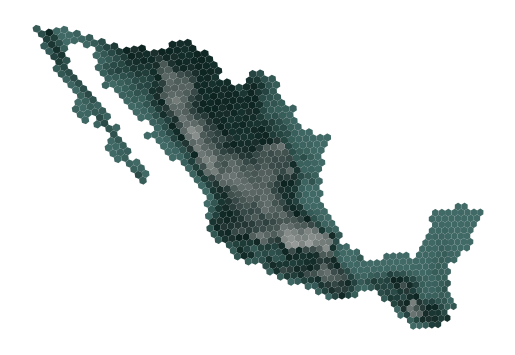

In [92]:
from matplotlib.colors import LinearSegmentedColormap

xds = xarray.open_dataset("assets/gis/elevation/ETOPO2v2c_f4.nc")
xds["z"].rio.to_raster("assets/gis/elevation/world_elevation.tif")

with rasterio.open("assets/gis/elevation/world_elevation.tif") as src_dst:
    with WarpedVRT(
        src_dst,
        src_crs=src_dst.gcps[1],
        src_transform=transform.from_gcps(src_dst.gcps[0]),
    ) as vrt:
        mean_elev = []
        for stat in rasterstats.zonal_stats(
            mexico_h3,
            vrt.read(1),
            affine=vrt.transform,
            stats="mean"
        ):
            mean_elev.append(stat["mean"])
        mexico_h3["mean_elev"] = mean_elev

colors = ["#416A66", "#0C2320", "#989C9A"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

mexico_h3.plot(column="mean_elev", cmap=cmap1, vmin=0)
plt.axis("off")
#plt.savefig("figures/elevation_by_deme.svg")
plt.show()

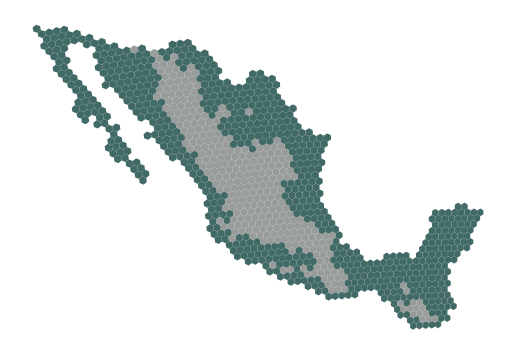

In [93]:
bins = [-10000, 1500, 10000]
mexico_h3["binned_elev"] = np.searchsorted(bins, mexico_h3["mean_elev"].values)
mexico_h3.plot(column="binned_elev", cmap=cmap1, vmin=1)
plt.axis("off")
plt.show()

In [94]:
sample_locs = pd.read_csv("assets/maize_from_regina/twoteos_sub_geolocation.csv")
sample_locs = gpd.GeoDataFrame(sample_locs, geometry=gpd.GeoSeries.from_xy(sample_locs["longitude"], sample_locs["latitude"]), crs=4326)
sample_locs_with_region = gpd.sjoin(sample_locs, mexico_h3, how="inner", predicate="within").loc[:, ["sample", "deme"]]
regions_with_samples = sample_locs_with_region["deme"].unique()

In [62]:
#with open("samples.tsv", "w") as sample_file:
#    sample_file.write("id\tdeme\n")
#    for sample in ts.samples():
#        individual = ts.individual(ts.node(sample).individual).metadata["id"]
#        sample_file.write(f"{sample}\t{sample_locs_with_region.loc[sample_locs_with_region["sample"]==individual, "deme"].iloc[0]}\n")

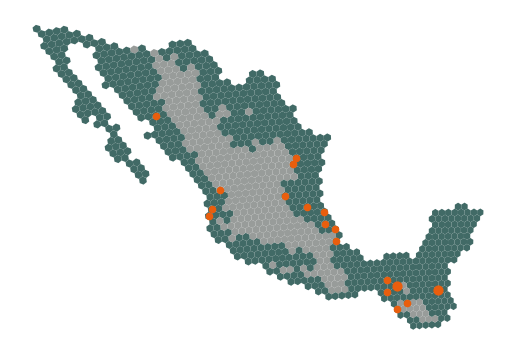

In [95]:
deme_sample_counts = sample_locs_with_region.value_counts("deme").reset_index()

base = mexico_h3.plot(column="binned_elev", cmap=cmap1, vmin=1)
for i,row in mexico_h3.iterrows():
    count = sum(deme_sample_counts.loc[deme_sample_counts["deme"]==row["deme"], "count"])
    if count > 0:
        center = row["geometry"].centroid
        plt.scatter(center.x, center.y, s=count*20, color="#E95E0D")
plt.axis("off")
plt.savefig("elevation_by_deme_binned_2_samples.svg")
plt.show()

In [75]:
mexico_h3["geometry"] = mexico_h3.buffer(0.1)
with open("demes.tsv", "w") as outfile:
    outfile.write("id\txcoord\tycoord\ttype\tneighbours\n")
    for i, row in mexico_h3.iterrows():
        neighbors = np.array(mexico_h3[mexico_h3.geometry.touches(row['geometry'])].deme)
        #overlapping neighbors use if discrepances found with touches
        overlap = np.array(mexico_h3[mexico_h3.geometry.overlaps(row['geometry'])].deme)
        neighbors = [str(d) for d in np.sort(np.union1d(neighbors, overlap))]
        center = row["geometry"].centroid
        outfile.write(f"{row["deme"]}\t{center.x}\t{center.y}\t{row["binned_elev"]-1}\t{",".join(neighbors)}\n")

/var/folders/q8/b10jdgls4xvcv3wz767kf6f80000gn/T/ipykernel_34995/2271051912.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mexico_h3["geometry"] = mexico_h3.buffer(0.1)


In [100]:
from os import mkdir
import tskit
ts = tskit.load("assets/maize_from_regina/trees/twoteos.9.99.trees")

def create_trees_folder_from_ts(ts, output_path=".", gap_between_trees=1, discretize_time=False):
    #mkdir(f"{output_path}/trees")
    for i in range(0, ts.num_trees, gap_between_trees):
        tree = ts.at_index(i)
        interval = tree.interval
        print(i, interval)
        #single_tree_ts = ts.keep_intervals([interval], simplify=True).trim()
        #single_tree_ts.dump(f"{output_path}/trees/{i}.trees")

ts = ts.trim()
print(ts)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │    1046851║
╟───────────────┼───────────╢
║Sequence Length│159753796.0║
╟───────────────┼───────────╢
║Time Units     │    unknown║
╟───────────────┼───────────╢
║Sample Nodes   │         40║
╟───────────────┼───────────╢
║Total Size     │  214.4 MiB║
╚═══════════════╧═══════════╝
╔═══════════╤═════════╤═════════╤════════════╗
║Table      │Rows     │Size     │Has Metadata║
╠═══════════╪═════════╪═════════╪════════════╣
║Edges      │3,683,024│112.4 MiB│          No║
╟───────────┼─────────┼─────────┼────────────╢
║Individuals│       20│  1.0 KiB│         Yes║
╟───────────┼─────────┼─────────┼────────────╢
║Migrations │        0│  8 Bytes│          No║
╟───────────┼─────────┼─────────┼────────────╢
║Mutations  │  843,781│ 29.8 MiB│          No║
╟───────────┼─────────┼─────────┼────────────╢
║Nodes      │1,027,076│ 27.4 MiB│          No║
╟───────────┼─────────┼─────────┼────────────╢

In [101]:
create_trees_folder_from_ts(
    ts=ts,
    gap_between_trees=10000
)

0 Interval(left=0.0, right=7.406036524927913)
10000 Interval(left=659182.9212708387, right=659186.6242891011)
20000 Interval(left=1156783.4836581687, right=1156807.6866960002)
30000 Interval(left=1770851.5698616887, right=1770857.2646941198)
40000 Interval(left=2332979.5455064126, right=2332980.75995882)
50000 Interval(left=2831192.8576719244, right=2831203.7877435894)
60000 Interval(left=3425144.50954661, right=3425710.4336329764)
70000 Interval(left=3867710.978769811, right=3867721.039642457)
80000 Interval(left=4319923.21572169, right=4319944.389928814)
90000 Interval(left=4903088.281820144, right=4903090.772903335)
100000 Interval(left=5221555.891008707, right=5221832.489351167)
110000 Interval(left=5717787.939331539, right=5717790.37632134)
120000 Interval(left=6391249.84490177, right=6391251.054771497)
130000 Interval(left=6904977.469165704, right=6905125.0732724015)
140000 Interval(left=7377541.711640696, right=7377713.323307631)
150000 Interval(left=7913581.247565678, right=791